## Test Problem

\begin{equation}
  \begin{gathered}
p=0 \text{ at } x=0\\
\frac{\partial p}{\partial x} = 0 \text{ at } x = L_x\\
p = 0 \text{ at }y = 0 \\
p = \sin \left(  \frac{\frac{3}{2}\pi x}{L_x} \right) \text{ at } y = L_y
  \end{gathered}
\end{equation}

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
# set the font family and size to use for Matplotlib figures
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
def plot_3d(x, y, p, label='$z$', elev=30.0, azim=45.0):
    """
    Creates a Matplotlib figure with a 3D surface plot
    of the scalar field p.

    Parameters
    ----------
    x : numpy.ndarray
        Gridline locations in the x direction as a 1D array of floats
    y : numpy.ndarray
        Gridline locations in the y direction as a 1D array of floats
    p : numpy.ndarray
        Scalar field to plot as a 2D array of floats
    label : string, optional
        Axis label to use in the third direction
        default: 'z'
    elev : float, optional
        Elevation angle in the z plane
        default: 30.0
    azim : float, optional
        Azimuth angle in the x,y plane
        default: 45.0
    """
    
    fig = pyplot.figure(figsize=(8.0, 6.0))
    ax = mplot3d.Axes3D(fig)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel(label)
    X, Y = numpy.meshgrid(x, y)
    
    ax.plot_surface(X, Y, p, cmap=cm.viridis)
    
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(y[0], y[-1])
    ax.view_init(elev=elev, azim=azim)

In [4]:
def laplace_solution(x, y, Lx, Ly):
    """
    Computes and returns the analytical solution of the Laplace equation
    on a given two-dimensional Cartesian grid.

    Parameters
    ----------
    x : numpy.ndarray
        The gridline locations in the x direction as a 1D array of floats
    y : numpy.ndarray
        The gridline locations in the y direction as a 1D array of floats
    Lx : float
        Length of the domain in the x direction
    Ly : float
        Length of the domain in the y direction

    Returns
    -------
    p : numpy.ndarray
        The analytical solution as a 2D array of floats
    """
    
    X, Y = numpy.meshgrid(x, y)
    p = (numpy.sinh(1.5 * numpy.pi * Y / Ly) /
         numpy.sinh(1.5 * numpy.pi * Ly / Lx) *
         numpy.sin(1.5 * numpy.pi * X / Lx))
    
    return p

In [5]:
def l2_norm(p, p_ref):
    """
    Computes and returns the relative L2-norm of the difference between
    a solution p and a reference solution p_ref.

    Parameters
    ----------
    p : numpy.ndarray
        The solution as an array of floats
    p_ref : numpy.ndarray
        The reference solution as an array of floats

    Returns
    -------
    diff : float
        The relative L2-norm of the difference
    """
    
    l2_diff = (numpy.sqrt(numpy.sum((p - p_ref)**2)) /
               numpy.sqrt(numpy.sum(p_ref**2)))
    
    return l2_diff

In [6]:
# parameters
nx = 128  # number of points in the x direction
ny = 128  # number of points in the y direction
Lx = 5.0  # domain length in the x direction
Ly = 5.0  # domain length in the y direction
dx = Lx / (nx - 1)  # grid spacing in x direction
dy = Ly / (ny - 1)  # grid spacing in y direction

# gridline locations.
x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

# ICs
p0 = numpy.zeros((ny, nx))
p0[-1, :] = numpy.sin(1.5 * numpy.pi * x / Lx)

In [7]:
def laplace_2d_jacobi(p0, maxiter=20000, rtol=1e-6):
    """
    Solves the 2D Laplace equation on a uniform grid with equal grid 
    spacing in both directions using Jacobi relaxation method.
    
    The exit criterion of the solver is based on the relative L2-norm
    of the solution difference between two consecutive iterations.
    
    Parameters
    ----------
    p0 : numpy.ndarray
        The initial solution as a 2D array of floats
    maxiter : integer, optional
        Maximum number of iterations to perform
        default: 20000
    rtol : float, optional
        Relative tolerance for convergence
        default: 1e-6
    
    Returns
    -------
    p : numpy.ndarray
        The solution after relaxation as a 2D array of floats
    ite : integer
        The number of iterations performed.
    diff : float
        The final relative L2-norm of the difference.
    """
    
    p = p0.copy()
    diff = rtol + 1.0  # initial difference
    ite = 0  # iteration index
    
    while diff > rtol and ite < maxiter:
        pn = p.copy()
        
        # update the solution at interior points
        p[1:-1, 1:-1] = 0.25 * (pn[1:-1, :-2] + pn[1:-1, 2:] +
                                pn[:-2, 1:-1] + pn[2:, 1:-1])
        
        # 2nd-order Neumann condition (zero-gradient) at right boundary
        p[1:-1, -1] = 0.25 * (2.0 * pn[1:-1, -2] +
                              pn[2:, -1] + pn[:-2, -1])
        
        # relative L2-norm of the difference
        diff = l2_norm(p, pn)
        ite += 1
    
    return p, ite, diff

In [8]:
p, ites, diff = laplace_2d_jacobi(p0, maxiter=20000, rtol=1e-8)
print('Jacobi relaxation: {} iterations '.format(ites) +
      'to reach a relative difference of {}'.format(diff))

Jacobi relaxation: 19993 iterations to reach a relative difference of 9.998616841218672e-09


In [9]:
%%timeit
laplace_2d_jacobi(p0, maxiter=20000, rtol=1e-8)

1 loop, best of 3: 4.58 s per loop


In [10]:
# compute the analytical solution
p_exact = laplace_solution(x, y, Lx, Ly)

# compute the relative L2-norm of the error
l2_norm(p, p_exact)

6.1735513352873561e-05

## Gauss-Seidel

\begin{equation}
p^{k+1}_{i,j} = \frac{1}{4} \left(p^{k+1}_{i,j-1} + p^k_{i,j+1} + p^{k+1}_{i-1,j} + p^k_{i+1,j} \right)
\end{equation}

In [11]:
def laplace_2d_gauss_seidel(p0, maxiter=20000, rtol=1e-6):
    """
    Solves the 2D Laplace equation on a uniform grid with equal grid 
    spacing in both directions using Gauss-Seidel relaxation method.
    
    The exit criterion of the solver is based on the relative L2-norm
    of the solution difference between two consecutive iterations.
    
    Parameters
    ----------
    p0 : numpy.ndarray
        The initial solution as a 2D array of floats
    maxiter : integer, optional
        Maximum number of iterations to perform
        default: 20000
    rtol : float, optional
        Relative tolerance for convergence
        default: 1e-6
    
    Returns
    -------
    p : numpy.ndarray
        The solution after relaxation as a 2D array of floats
    ite : integer
        The number of iterations performed
    diff : float
        The final relative L2-norm of the difference
    """
    
    ny, nx = p0.shape
    p = p0.copy()
    diff = rtol + 1.0  # initial difference
    ite = 0  # iteration index
    
    while diff > rtol and ite < maxiter:
        pn = p.copy()
        
        # update the solution at interior points.
        for j in range(1, ny - 1):
            for i in range(1, nx - 1):
                p[j, i] = 0.25 * (p[j, i - 1] + p[j, i + 1] +
                                  p[j - 1, i] + p[j + 1, i])
        # 2nd-order Neumann condition (zero-gradient) at right boundary
        for j in range(1, ny - 1):
            p[j, -1] = 0.25 * (2.0 * p[j, -2] +
                               p[j - 1, -1] + p[j + 1, -1])
        
        # relative L2-norm of the difference
        diff = l2_norm(p, pn)
        ite += 1
        
    return p, ite, diff

In [12]:
import numba
from numba import jit

In [13]:
def fib_it(n):
    a, b = 1, 1
    for i in range(n - 2):
        a, b = b, a + b
    return b

In [14]:
%%timeit
fib_it(500000)

1 loop, best of 3: 4.72 s per loop


In [15]:
@jit(nopython=True)
def fib_it(n):
    a, b = 1, 1
    for i in range(n - 2):
        a, b = b, a + b
    return b

In [16]:
%%timeit
fib_it(500000)

The slowest run took 371.11 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 669 µs per loop


In [17]:
print(numba.__version__)

0.40.0


In [18]:
@jit(nopython=True)
def laplace_2d_jacobi(p0, maxiter=20000, rtol=1e-6):
    """
    Solves the 2D Laplace equation on a uniform grid with equal grid 
    spacing in both directions using Jacobi relaxation method.
    
    The exit criterion of the solver is based on the relative L2-norm
    of the solution difference between two consecutive iterations.
    
    Parameters
    ----------
    p0 : numpy.ndarray
        The initial solution as a 2D array of floats
    maxiter : integer, optional
        Maximum number of iterations to perform
        default: 20000
    rtol : float, optional
        Relative tolerance for convergence
        default: 1e-6
    
    Returns
    -------
    p : numpy.ndarray
        The solution after relaxation as a 2D array of floats
    ite : integer
        The number of iterations performed.
    diff : float
        The final relative L2-norm of the difference.
    """
    
    ny, nx = p0.shape
    p = p0.copy()
    conv = []  # convergence history
    diff = rtol + 1.0  # initial difference
    ite = 0  # iteration index
    
    while diff > rtol and ite < maxiter:
        pn = p.copy()
        
        # update the solution at interior points.
        for j in range(1, ny - 1):
            for i in range(1, nx - 1):
                p[j, i] = 0.25 * (pn[j, i - 1] + pn[j, i + 1] +
                                  pn[j - 1, i] + pn[j + 1, i])
        
        # 2nd-order Neumann condition (zero-gradient) at right boundary
        for j in range(1, ny - 1):
            p[j, -1] = 0.25 * (2.0 * pn[j, -2] +
                               pn[j - 1, -1] + pn[j + 1, -1])
        
        # relative L2-norm of the difference
        diff = numpy.sqrt(numpy.sum((p - pn)**2) / numpy.sum(pn**2))
        conv.append(diff)
        ite += 1
    return p, ite, conv

In [19]:
p, ites, conv_jacobi = laplace_2d_jacobi(p0,
                                         maxiter=20000, rtol=1e-8)
print('Jacobi relaxation: {} iterations '.format(ites) +
      'to reach a relative difference of {}'.format(conv_jacobi[-1]))

Jacobi relaxation: 19993 iterations to reach a relative difference of 9.998616841252205e-09


In [20]:
%%timeit
laplace_2d_jacobi(p0, maxiter=20000, rtol=1e-8)

1 loop, best of 3: 2.62 s per loop


In [21]:
@jit(nopython=True)
def laplace_2d_gauss_seidel(p0, maxiter=20000, rtol=1e-6):
    """
    Solves the 2D Laplace equation on a uniform grid
    with equal grid spacing in both directions
    using Gauss-Seidel relaxation method.
    
    The exit criterion of the solver is based on the relative L2-norm
    of the solution difference between two consecutive iterations.
    
    Parameters
    ----------
    p0 : numpy.ndarray
        The initial solution as a 2D array of floats.
    maxiter : integer, optional
        Maximum number of iterations to perform;
        default: 20000.
    rtol : float, optional
        Relative tolerance for convergence;
        default: 1e-6.
    
    Returns
    -------
    p : numpy.ndarray
        The solution after relaxation as a 2D array of floats.
    ite : integer
        The number of iterations performed.
    conv : list
        The convergence history as a list of floats.
    """
    
    ny, nx = p0.shape
    p = p0.copy()
    conv = []  # convergence history
    diff = rtol + 1.0  # initial difference
    ite = 0  # iteration index

    while diff > rtol and ite < maxiter:
        pn = p.copy()
        
        # update the solution at interior points
        for j in range(1, ny - 1):
            for i in range(1, nx - 1):
                p[j, i] = 0.25 * (p[j, i - 1] + p[j, i + 1] +
                                  p[j - 1, i] + p[j + 1, i])
        
        # 2nd-order Neumann condition (zero-gradient) at right boundary
        for j in range(1, ny - 1):
            p[j, -1] = 0.25 * (2.0 * p[j, -2] +
                               p[j - 1, -1] + p[j + 1, -1])
        
        # compute the relative L2-norm of the difference
        diff = numpy.sqrt(numpy.sum((p - pn)**2) / numpy.sum(pn**2))
        conv.append(diff)
        ite += 1
    
    return p, ite, conv

In [22]:
p, ites, conv_gs = laplace_2d_gauss_seidel(p0,
                                           maxiter=20000, rtol=1e-8)
print('Gauss-Seidel relaxation: {} iterations '.format(ites) +
      'to reach a relative difference of {}'.format(conv_gs[-1]))

Gauss-Seidel relaxation: 13939 iterations to reach a relative difference of 9.997635651907134e-09


In [23]:
%%timeit
laplace_2d_gauss_seidel(p0, maxiter=20000, rtol=1e-8)

1 loop, best of 3: 4.06 s per loop


## Successive Over Relaxation (SOR)

\begin{equation}
p^{k+1}_{i,j} = (1 - \omega)p^k_{i,j} + \frac{\omega}{4} \left(p^{k+1}_{i,j-1} + p^k_{i,j+1} + p^{k+1}_{i-1,j} + p^k_{i+1,j} \right)
\end{equation}

If $\omega<1$, that is technically an "under-relaxation" and it will be slower than Gauss-Seidel.
If $\omega>1$, that's the over-relaxation and it should converge faster than Gauss-Seidel.

In [24]:
@jit(nopython=True)
def laplace_2d_sor(p0, omega, maxiter=20000, rtol=1e-6):
    """
    Solves the 2D Laplace equation on a uniform grid with equal grid 
    spacing in both directions using successive over-relaxation (SOR) 
    method.
    
    The exit criterion of the solver is based on the relative L2-norm
    of the solution difference between two consecutive iterations.
    
    Parameters
    ----------
    p0 : numpy.ndarray
        The initial solution as a 2D array of floats
    omega : float
        Relaxation parameter
    maxiter : integer, optional
        Maximum number of iterations to perform
        default: 20000
    rtol : float, optional
        Relative tolerance for convergence
        default: 1e-6
    
    Returns
    -------
    p : numpy.ndarray
        The solution after relaxation as a 2D array of floats
    ite : integer
        The number of iterations performed
    conv : list
        The convergence history as a list of floats
    """
    
    ny, nx = p0.shape
    p = p0.copy()
    conv = []  # convergence history
    diff = rtol + 1.0  # initial difference
    ite = 0  # iteration index
    
    while diff > rtol and ite < maxiter:
        pn = p.copy()
        
        # update the solution at interior points
        for j in range(1, ny - 1):
            for i in range(1, nx - 1):
                p[j, i] = ((1.0 - omega) * p[j, i] +
                           omega * 0.25 *(p[j, i - 1] + p[j, i + 1] +
                                          p[j - 1, i] + p[j + 1, i]))
        
        # 2nd-order Neumann condition (zero-gradient) at right boundary
        for j in range(1, ny - 1):
            p[j, -1] = 0.25 * (2.0 * p[j, -2] +
                               p[j - 1, -1] + p[j + 1, -1])
        
        # relative L2-norm of the difference
        diff = numpy.sqrt(numpy.sum((p - pn)**2) / numpy.sum(pn**2))
        conv.append(diff)
        ite += 1
    
    return p, ite, conv

In [25]:
omega = 1.0
p, ites, conv_sor = laplace_2d_sor(p0, omega,
                                   maxiter=20000, rtol=1e-8)
print('SOR (omega={}): {} iterations '.format(omega, ites) +
      'to reach a relative difference of {}'.format(conv_sor[-1]))

SOR (omega=1.0): 13939 iterations to reach a relative difference of 9.997635651907134e-09


In [26]:
omega = 1.5
p, ites, conv_sor = laplace_2d_sor(p0, omega,
                                   maxiter=20000, rtol=1e-8)
print('SOR (omega={}): {} iterations '.format(omega, ites) +
      'to reach a relative difference of {}'.format(conv_sor[-1]))

SOR (omega=1.5): 7108 iterations to reach a relative difference of 9.991011444054683e-09


In [27]:
%%timeit
laplace_2d_sor(p0, omega, maxiter=20000, rtol=1e-8)

1 loop, best of 3: 2.45 s per loop


### Tuned SOR

\begin{equation}
\omega \approx \frac{2}{1+\frac{\pi}{nx}}
\end{equation}

In [28]:
omega = 2.0 / (1.0 + numpy.pi / nx)
p, ites, conv_opt_sor = laplace_2d_sor(p0, omega,
                                       maxiter=20000, rtol=1e-8)
print('SOR (omega={:.4f}): {} iterations '.format(omega, ites) +
      'to reach a relative difference of {}'.format(conv_opt_sor[-1]))

SOR (omega=1.9521): 1110 iterations to reach a relative difference of 9.964283921218177e-09


In [29]:
%%timeit
laplace_2d_sor(p0, omega, maxiter=20000, rtol=1e-8)

1 loop, best of 3: 391 ms per loop


In [30]:
# relative L2-norm of the error
l2_norm(p, p_exact)

7.7927433550429743e-05

## Decay of Difference Between Iterates

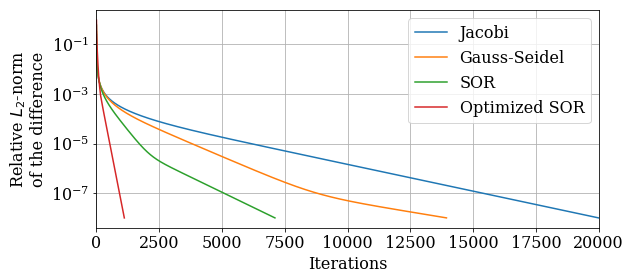

In [31]:
# plot the convergence history for different methods
pyplot.figure(figsize=(9.0, 4.0))
pyplot.xlabel('Iterations')
pyplot.ylabel('Relative $L_2$-norm\nof the difference')
pyplot.grid()
pyplot.semilogy(conv_jacobi, label='Jacobi')
pyplot.semilogy(conv_gs, label='Gauss-Seidel')
pyplot.semilogy(conv_sor, label='SOR')
pyplot.semilogy(conv_opt_sor, label='Optimized SOR')
pyplot.legend()
pyplot.xlim(0, 20000);